Topic- X-ray Image Classification:
Build a deep learning model to classify chest X-ray images as normal or showing signs of Pneumonia.

Pneumonia Detection Using Deep Learning Approaches: https://ieeexplore.ieee.org/abstract/document/9077899
Abstract:
Pneumonia is among the most prevalent diseases, and due to lack of experts it is difficult to detect. This paper focuses on surveying and comparing the detection of lung disease using different computer-aided techniques and suggests a revised model for detecting pneumonia, which will then be implemented as part of our future research. In this survey, we also tried to familiarize ourselves with the different image pre-processing techniques used to convert raw X-ray images into standard formats for analysis and detection, machine learning techniques such as CNN, RESNET, CheXNet, DENSENET, ANN and KNN, which is an important phase in accurate pneumonia detection.
As we can see that above paper used RESNET, DenseNet models for pneumonia classification
But we will be trying to use VGG19 model in the pneumonia detection from chest Xray images

The dataset we are using is:
Chest X-Ray Images (Pneumonia): https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline
from tensorflow.keras.models import Model, save_model, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPooling2D, SeparableConv2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import h5py
import cv2
import os
import random
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# If a GPU is accessible, it will display the name of the GPU device
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
paths = {
    'train' : '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    'val' : '/kaggle/input/chest-xray-pneumonia/chest_xray/val',
    'test' : '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
}

classes = ['NORMAL', 'PNEUMONIA']

In [4]:
#Exploratory Data Analysis

def len_files(folder_name):
    """
    return the number of files in each class
    """
    for i in range(2):
        os.chdir(os.path.join(paths[folder_name], classes[i]))
        files = sorted(os.listdir())
        len_images = 0
        len_others = 0
        for file in files:
            extension = file.split('.')[1]
            if extension == 'jpeg':
                len_images += 1
            else:
                len_others += 1
        print(f"The numebr of image files in the class {classes[i]} of the {folder_name} is {len_images}")
        print(f"The numebr of other files in the class {classes[i]} of the {folder_name} is {len_others}")
    print('--------------')

In [5]:
len_files('train')
len_files('val')
len_files('test')

The numebr of image files in the class NORMAL of the train is 1341
The numebr of other files in the class NORMAL of the train is 0
The numebr of image files in the class PNEUMONIA of the train is 3875
The numebr of other files in the class PNEUMONIA of the train is 0
--------------
The numebr of image files in the class NORMAL of the val is 8
The numebr of other files in the class NORMAL of the val is 0
The numebr of image files in the class PNEUMONIA of the val is 8
The numebr of other files in the class PNEUMONIA of the val is 0
--------------
The numebr of image files in the class NORMAL of the test is 234
The numebr of other files in the class NORMAL of the test is 0
The numebr of image files in the class PNEUMONIA of the test is 390
The numebr of other files in the class PNEUMONIA of the test is 0
--------------


In [6]:
os.chdir(paths['train'])

In [7]:
def show_images(folder_name, class_name, num_im, random_state=42):
    im_files = os.listdir(os.path.join(paths[folder_name.lower()], class_name.upper()))
    random.seed(random_state)
    rand_images = random.choices(im_files, k=num_im)
    plt.figure(figsize=(20, 20))
    for i, im in enumerate(rand_images):
        ax = plt.subplot(num_im, 1, i + 1)
        im_arr = cv2.imread(os.path.join(paths[folder_name.lower()], class_name.upper(), im))
        ax.imshow(im_arr, cmap='gray')
        ax.set_title(f'{class_name.upper()}', alpha=.7)
        plt.axis('off')
        plt.tight_layout()

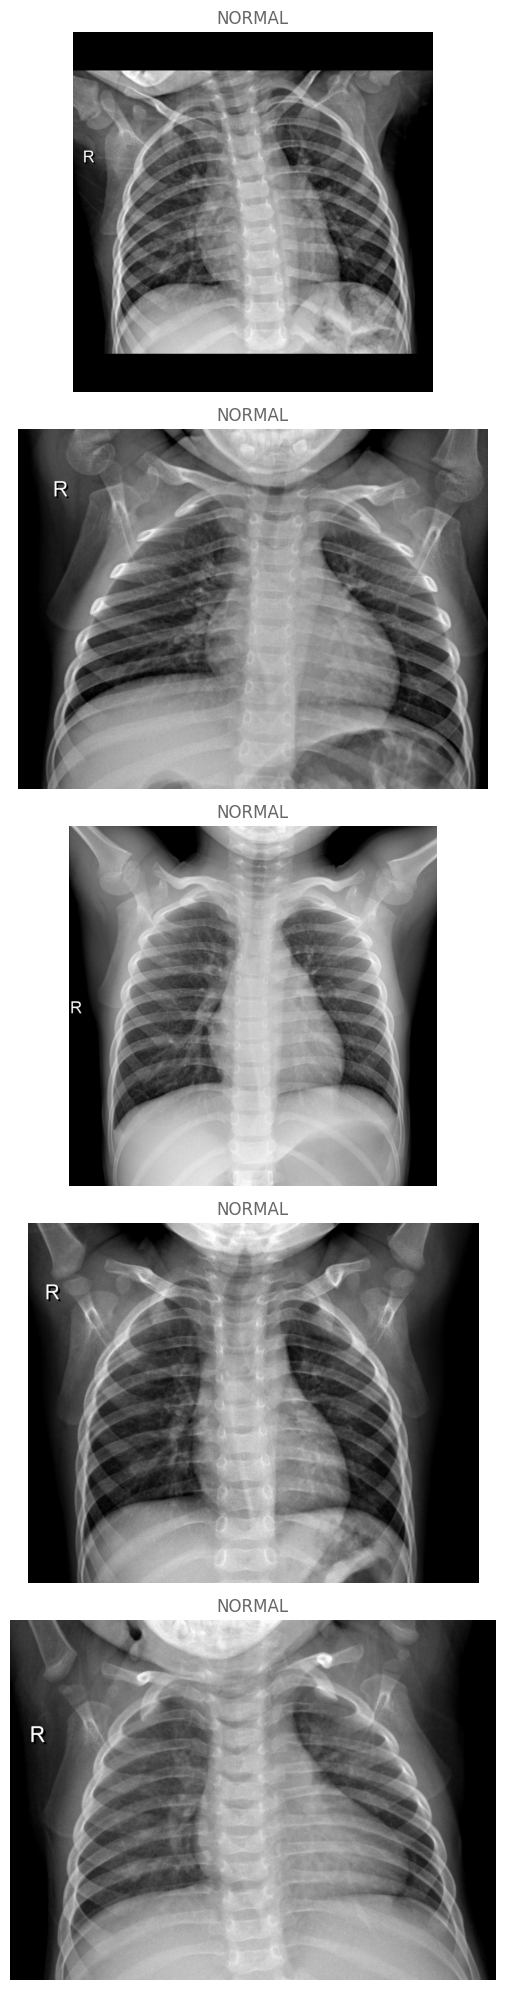

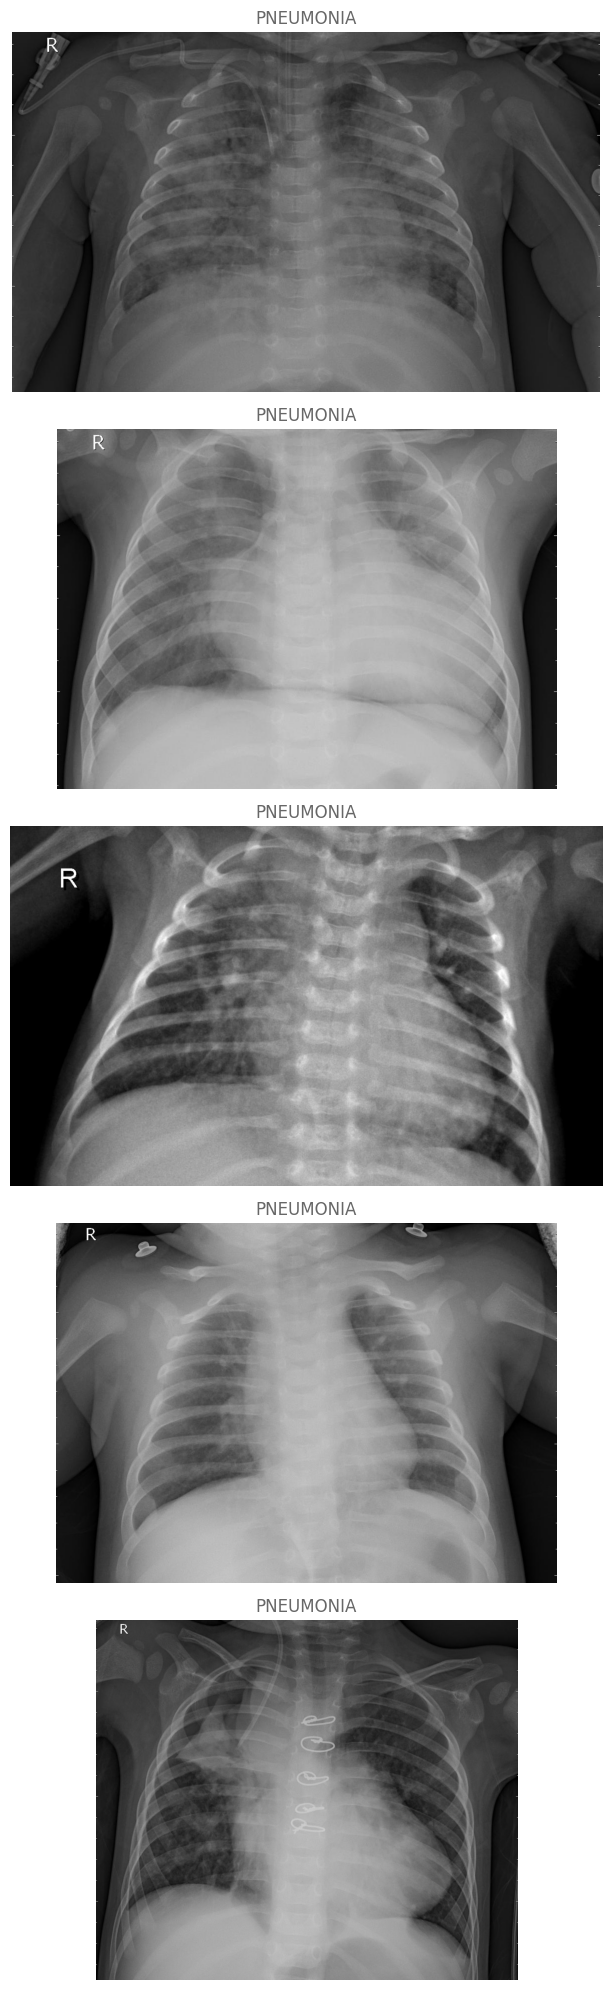

In [8]:
#Displaying images of Normal X rays images
show_images('train', 'normal', 5)
#Showing images of Pneumonia X ray Images
show_images('train', 'Pneumonia', 5)

In [9]:
# Data Preprocessing
# 1- Data Augmentation:
# we will be making more data from the available data by doing data augmentation

def create_datagen():
    return ImageDataGenerator(rescale= 1./ 255.)

train_datagen = create_datagen()
val_datagen = create_datagen()
test_datagen = create_datagen()

In [10]:
# The method datagen.flow_from_directory creates a continuous flow of augmented data batches 
# by reading images from a directory structure for training a machine learning model.

BATCH_SIZE = 16
print('Training Set:')
train_set = train_datagen.flow_from_directory(
    paths['train'],
    color_mode= 'rgb',
    class_mode= 'binary',
    target_size= (224, 224),
    batch_size= BATCH_SIZE
)

print('validation Set:')
val_set = train_datagen.flow_from_directory(
    paths['val'],
    color_mode= 'rgb',
    class_mode= 'binary',
    target_size= (224, 224),
    batch_size= BATCH_SIZE
)

print('Test Set:')
test_set = test_datagen.flow_from_directory(
    paths['test'],
    color_mode= 'rgb',
    class_mode= 'binary',
    target_size= (224, 224),
    batch_size= BATCH_SIZE
)

Training Set:
Found 5216 images belonging to 2 classes.
validation Set:
Found 16 images belonging to 2 classes.
Test Set:
Found 624 images belonging to 2 classes.


In [13]:
#Building a VGG19 Model

def building_model():
    # Create a CNN architecture
    # block1
    input_layer = Input(shape=(224,224,3), name='input_layer')
    block1_conv1 = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv1')(input_layer)
    block1_conv2 = Conv2D(64, (3,3), activation='relu', padding='same', name='block1_conv2')(block1_conv1)
    block1_pool1 = MaxPooling2D((2,2), name='block1_pool1')(block1_conv2)
    
    # block2
    block2_conv1 = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='block2_conv1')(block1_pool1)
    block2_conv2 = SeparableConv2D(128, (3,3), activation='relu', padding='same', name='block2_conv2')(block2_conv1)
    block2_pool1 = MaxPooling2D((2,2), name='block2_pool1')(block2_conv2)
    
    # block3
    block3_conv1 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='block3_conv1')(block2_pool1)
    block3_bn1 = BatchNormalization(name='block3_bn1')(block3_conv1)
    block3_conv2 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='block3_conv2')(block3_bn1)
    block3_bn2 = BatchNormalization(name='block3_bn2')(block3_conv2)
    block3_conv3 = SeparableConv2D(256, (3,3), activation='relu', padding='same', name='block3_conv3')(block3_bn2)
    block3_pool1 = MaxPooling2D((2,2), name='block3_pool1')(block3_conv3)

    # block4
    block4_conv1 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block4_conv1')(block3_pool1)
    block4_bn1 = BatchNormalization(name='block4_bn1')(block4_conv1)
    block4_conv2 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block4_conv2')(block4_bn1)
    block4_bn2 = BatchNormalization(name='block4_bn2')(block4_conv2)
    block4_conv3 = SeparableConv2D(512, (3,3), activation='relu', padding='same', name='block4_conv3')(block4_bn2)
    block4_pool1 = MaxPooling2D((2,2), name='block4_pool1')(block4_conv3)
    
    # block5
    flatten = Flatten(name='flatten')(block4_pool1)
    block5_dense1 = Dense(1024, activation='relu', name='block5_dense1')(flatten)
    block5_drop1 = Dropout(0.7, name='block5_drop1')(block5_dense1)
    block5_dense2 = Dense(512, activation='relu', name='block5_dense2')(block5_drop1)
    block5_drop2 = Dropout(0.5, name='block5_drop2')(block5_dense2)
    output_layer = Dense(1, activation='sigmoid', name='output_layer')(block5_drop2)
    
    vgg = Model(inputs=input_layer, outputs=output_layer)
    
    # Nowe, We want to initialize the weights of the first four convolution layers with imagenet weights .
    # During training phase, The weights of VGG layers are not updated because they are freeze.
    vgg19_weights = h5py.File('/kaggle/input/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r') # Open the VGG19 weight file

    # First, Select weights and bias and then assign them to desired convolution layers, The first four convolution layers.
    w,b = vgg19_weights['block1_conv1']['block1_conv1_W_1:0'], vgg19_weights['block1_conv1']['block1_conv1_b_1:0']
    vgg.layers[1].set_weights = [w,b]

    w,b = vgg19_weights['block1_conv2']['block1_conv2_W_1:0'], vgg19_weights['block1_conv2']['block1_conv2_b_1:0']
    vgg.layers[2].set_weights = [w,b]

    w,b = vgg19_weights['block2_conv1']['block2_conv1_W_1:0'], vgg19_weights['block2_conv1']['block2_conv1_b_1:0']
    vgg.layers[4].set_weights = [w,b]

    w,b = vgg19_weights['block2_conv2']['block2_conv2_W_1:0'], vgg19_weights['block2_conv2']['block2_conv2_b_1:0']
    vgg.layers[5].set_weights = [w,b]
    vgg19_weights.close()
    
    # Now, It's time to compile it. 
    vgg.compile(
        loss = 'binary_crossentropy',
        optimizer = Adam(learning_rate=0.0001),
        metrics = ['binary_accuracy']
    )
    return vgg

In [14]:
with tf.device(tf.test.gpu_device_name()):
    vgg = building_model()
vgg.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool1 (MaxPooling2D)  (None, 112, 112, 64)     0         
                                                                 
 block2_conv1 (SeparableConv  (None, 112, 112, 128)    8896      
 2D)                                                             
                                                                 
 block2_conv2 (SeparableConv  (None, 112, 112, 128)    17664     
 2D)                                                         

In [15]:
#Training the model

EPOCHS = 5
STEPS_PER_EPOCH = len(train_set)
VALIDATION_STEPS = len(val_set)
ES = EarlyStopping(monitor='val_loss', patience=5)
MC = ModelCheckpoint("/kaggle/working/model_weights.h5", monitor='val_loss', save_best_only=True)
RLR = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=.2)
CLASS_WEIGHT = {0:1.0, 1:0.4}


history = vgg.fit(
    x=train_set,
    validation_data= val_set,
    epochs= EPOCHS,
    steps_per_epoch= STEPS_PER_EPOCH,
    validation_steps= VALIDATION_STEPS,
    callbacks= [ES, MC, RLR],
    class_weight= CLASS_WEIGHT
)

Epoch 1/5
326/326 [==============================] - 93s 238ms/step - loss: 0.2567 - binary_accuracy: 0.8121 - val_loss: 0.9277 - val_binary_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/5
326/326 [==============================] - 47s 145ms/step - loss: 0.1008 - binary_accuracy: 0.9225 - val_loss: 3.7253 - val_binary_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 3/5
326/326 [==============================] - 51s 156ms/step - loss: 0.0789 - binary_accuracy: 0.9459 - val_loss: 0.3928 - val_binary_accuracy: 0.8750 - lr: 1.0000e-04
Epoch 4/5
326/326 [==============================] - 47s 145ms/step - loss: 0.0633 - binary_accuracy: 0.9565 - val_loss: 3.5403 - val_binary_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 5/5
326/326 [==============================] - 50s 154ms/step - loss: 0.0524 - binary_accuracy: 0.9664 - val_loss: 0.3082 - val_binary_accuracy: 0.8125 - lr: 1.0000e-04


In [31]:
class_names=train_set.class_indices
print(class_names)

li = list(class_names.keys())
print(li)

{'NORMAL': 0, 'PNEUMONIA': 1}
['NORMAL', 'PNEUMONIA']


In [37]:
import cv2
image=cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg")
image_resize=cv2.resize(image,(224,224))
image=np.expand_dims(image_resize,axis=0)
print(image.shape)

pred=vgg.predict(image)
print(pred)



(1, 224, 224, 3)
1/1 [==============================] - 0s 21ms/step
[[1.]]


In [38]:
import cv2
image=cv2.imread("/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg")
image_resize=cv2.resize(image,(224,224))
image=np.expand_dims(image_resize,axis=0)
print(image.shape)

pred=vgg.predict(image)
print(pred)



(1, 224, 224, 3)
1/1 [==============================] - 0s 22ms/step
[[1.]]


In [16]:
# Save the trained model
vgg.save("/kaggle/working/pneumonia_model.h5")

In [17]:
# Load the saved model

loaded_model = load_model("/kaggle/working/pneumonia_model.h5")

# Now, you can use the loaded model to make predictions on new images
def predict_pneumonia(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Ensure the image size matches the model's input size
    img = img / 255.0  # Normalize the image
    img = img.reshape(1, 224, 224, 3)  # Reshape the image to match the input shape of the model

    # Make predictions
    predictions = loaded_model.predict(img)

    # Interpret the predictions (0: NORMAL, 1: PNEUMONIA)
    if predictions[0] <= 0.5:
        return "NORMAL"
    else:
        return "PNEUMONIA"

In [20]:
# Example usage:
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg"  # Replace with the path to your image
result = predict_pneumonia(image_path)
print(f"Prediction: {result}")

1/1 [==============================] - 0s 21ms/step
Prediction: NORMAL


In [21]:
# Example usage:
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg"  # Replace with the path to your image
result = predict_pneumonia(image_path)
print(f"Prediction: {result}")

1/1 [==============================] - 0s 23ms/step
Prediction: NORMAL


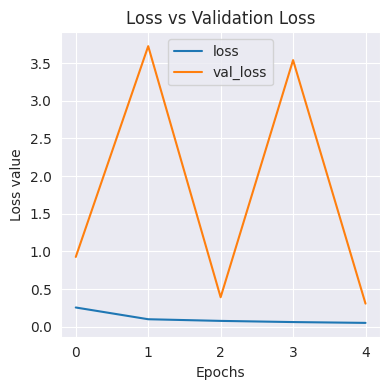

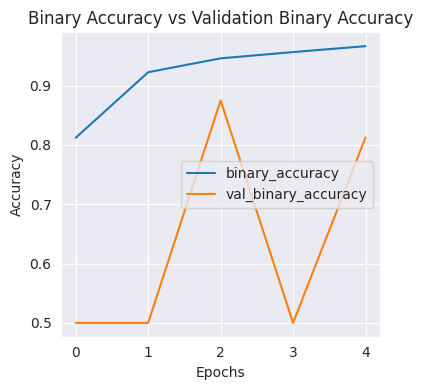

In [22]:
#Visualization the Learning of the model

plt.figure(figsize=(4,4))
plt.plot(history.history['loss'], label='loss');
plt.plot(history.history['val_loss'], label='val_loss');
plt.legend();
plt.title('Loss vs Validation Loss');
plt.xlabel("Epochs")
plt.ylabel("Loss value")
plt.tight_layout();

plt.figure(figsize=(4,4))
plt.plot(history.history['binary_accuracy'], label='binary_accuracy');
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy');
plt.legend();
plt.title('Binary Accuracy vs Validation Binary Accuracy');
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.tight_layout();

In [23]:
#Evaluating model on Test Set

def get_len_smaller_50_and_len_bigger_50(y_pred_or_y_true):
    """
    Performing some tasks to find the number of items is smaller than 0.5 and to equal or bigger than 0.5.
    """
    len_smaller_50 = 0
    for num in sorted(y_pred_or_y_true):
        if num < .5:
            len_smaller_50 += 1
    len_bigger_50 = len(test_set.classes) - len_smaller_50
    return len_smaller_50, len_bigger_50

In [24]:
len_smaller_50, len_bigger_50 = get_len_smaller_50_and_len_bigger_50(test_set.classes)
print(f"The number of items that are smaller than 0.5 is {len_smaller_50}")
print(f"The number of items that are equal or bigger than 0.5 is {len_bigger_50}")

The number of items that are smaller than 0.5 is 234
The number of items that are equal or bigger than 0.5 is 390


In [25]:
len_smaller_50, len_bigger_50 = get_len_smaller_50_and_len_bigger_50(vgg.predict(test_set).reshape(-1))
print(f"The number of items that are smaller than 50 is {len_smaller_50}")
print(f"The number of items that are equal or bigger than 50 is {len_bigger_50}")

39/39 [==============================] - 9s 214ms/step
The number of items that are smaller than 50 is 178
The number of items that are equal or bigger than 50 is 446


In [26]:
y_preds = sorted(vgg.predict(test_set).flatten())
predicted_classes = [0 if y_pred < .5 else 1 for y_pred in y_preds]

39/39 [==============================] - 5s 128ms/step


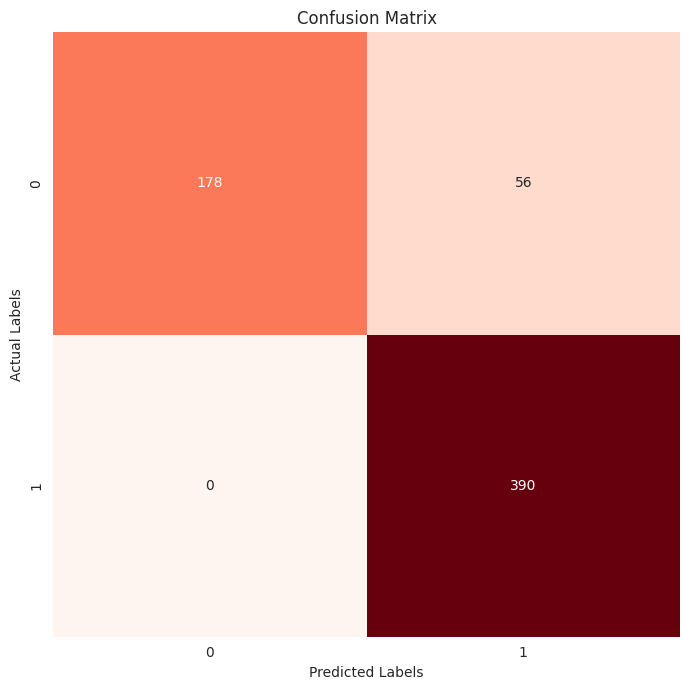

In [27]:
conf_matrix = confusion_matrix(y_true= test_set.classes, y_pred= predicted_classes)
plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Reds');
plt.title('Confusion Matrix');
plt.xlabel('Predicted Labels');
plt.ylabel('Actual Labels');
plt.tight_layout();

In [28]:
print(classification_report(test_set.classes, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       234
           1       0.87      1.00      0.93       390

    accuracy                           0.91       624
   macro avg       0.94      0.88      0.90       624
weighted avg       0.92      0.91      0.91       624

